In [23]:
# **1. Imports Section**

In [24]:
# --- Main Script ---
import os
import shutil
import pandas as pd
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import pipeline
from langchain_core.documents import Document
import warnings
warnings.filterwarnings("ignore")

# Add to your imports section
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics.pairwise import cosine_similarity
import shap  # For SHAP explanations
from sklearn.ensemble import RandomForestClassifier  # For feature importance

# --- Configuration ---
DATA_DIR = "rag_data"
PDF_DIRS = ["research_papers", "clinical_studies", "fda_reports"]
HTML_DIRS = ["kennel_clubs", "vet_associations", "breeder_forums"]
STRUCTURED_DATA_PATH = os.path.join(DATA_DIR, "structured", "breed_health_data.xlsx")
VECTOR_DB_PATH = os.path.join(DATA_DIR, "unstructured", "vector_db")
VECTOR_DB_CACHE_PATH = os.path.join(DATA_DIR, "unstructured", "vector_db_cache")
VECTOR_DB_READY_FLAG = os.path.join(VECTOR_DB_CACHE_PATH, ".ready")

# --- Document Loading ---

In [25]:
def load_documents():
    docs = []
    print("\n[Document Loading Progress]")
    
    # 1. Verify directory structure exists
    print("\n🔍 Verifying directory structure...")
    required_dirs = {
        "PDFs": [os.path.join(DATA_DIR, "unstructured", "pdfs", d) for d in PDF_DIRS],
        "HTML": [os.path.join(DATA_DIR, "unstructured", "web_articles", d) for d in HTML_DIRS],
        "Structured": [os.path.dirname(STRUCTURED_DATA_PATH)]
    }
    
    # Check and report missing directories
    for data_type, dirs in required_dirs.items():
        missing = [d for d in dirs if not os.path.exists(d)]
        if missing:
            print(f"⚠️ Missing {data_type} directories: {missing}")
        else:
            print(f"✓ All {data_type} directories present")

    # 2. Load structured data from Excel
    print("\n📂 Loading structured data...")
    if os.path.exists(STRUCTURED_DATA_PATH):
        print(f"Found Excel file at: {STRUCTURED_DATA_PATH}")
        try:
            df = pd.read_excel(STRUCTURED_DATA_PATH)
            records = df.to_dict('records')
            
            for record in records:
                content = "\n".join(f"{k}: {v}" for k, v in record.items())
                docs.append(Document(
                    page_content=content, 
                    metadata={"source": "structured_data"}
                ))
                
            print(f"    → Loaded {len(records)} structured records")
        except Exception as e:
            print(f"❌ Failed to load Excel: {type(e).__name__}: {str(e)[:100]}")
    else:
        print(f"⚠️ Structured data file not found: {STRUCTURED_DATA_PATH}")

    # 3. Load HTML files
    print("\n📂 Loading HTML files...")
    for folder in HTML_DIRS:
        full_path = os.path.join(DATA_DIR, "unstructured", "web_articles", folder)
        if not os.path.exists(full_path):
            print(f"⚠️ Skipping missing HTML folder: {full_path}")
            continue
            
        print(f"\nProcessing HTML folder: {full_path}")
        html_files = [f for f in os.listdir(full_path) if f.endswith(".html")]
        
        if not html_files:
            print("  No HTML files found")
            continue
            
        for file in html_files:
            file_path = os.path.join(full_path, file)
            try:
                print(f"  Processing: {file[:50]}...", end=" ")
                with open(file_path, 'rb') as f:
                    content = f.read().decode('utf-8', errors='replace')
                    if not content.strip():
                        print("⚠️ Empty, skipping")
                        continue
                
                loader = TextLoader(file_path, encoding='utf-8')
                loaded = loader.load()
                docs.extend(loaded)
                print(f"✅ {len(loaded)} chunks")
            except Exception as e:
                print(f"❌ {type(e).__name__}: {str(e)[:50]}")

    # 4. Load PDFs
    print("\n📂 Loading PDFs...")
    for folder in PDF_DIRS:
        full_path = os.path.join(DATA_DIR, "unstructured", "pdfs", folder)
        if not os.path.exists(full_path):
            print(f"⚠️ Skipping missing PDF folder: {full_path}")
            continue
            
        print(f"\nProcessing PDF folder: {full_path}")
        pdf_files = [f for f in os.listdir(full_path) if f.endswith(".pdf")]
        
        for file in pdf_files:
            file_path = os.path.join(full_path, file)
            try:
                print(f"  Processing: {file[:50]}...", end=" ")
                loader = PyPDFLoader(file_path)
                loaded = loader.load()
                docs.extend(loaded)
                print(f"✅ {len(loaded)} chunks")
            except Exception as e:
                print(f"❌ {str(e)[:50]}")

    print(f"\n📊 Total documents loaded: {len(docs)}")
    return docs

# --- Text Processing ---

In [26]:
def split_documents(documents):
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    return splitter.split_documents(documents)

# --- Vector Store Management ---

In [27]:


def is_vectorstore_ready():
    """Check if we have a pre-built vectorstore"""
    return os.path.exists(VECTOR_DB_READY_FLAG)

def build_or_load_vectorstore(docs, force_rebuild=False):
    """Smart function that only rebuilds when needed"""
    if not force_rebuild and is_vectorstore_ready():
        print("\n🔍 Loading existing vector store (use force_rebuild=True to regenerate)")
        return load_vectorstore(VECTOR_DB_CACHE_PATH)
    
    print("\n🔧 Building new vector store...")
    if os.path.exists(VECTOR_DB_CACHE_PATH):
        shutil.rmtree(VECTOR_DB_CACHE_PATH)
    
    vectorstore = build_vectorstore(docs, save_path=VECTOR_DB_CACHE_PATH)
    
    # Create a ready flag file
    with open(VECTOR_DB_READY_FLAG, 'w') as f:
        f.write("ready")
    
    return vectorstore

# Modify your existing build_vectorstore function to accept save_path parameter
def build_vectorstore(docs, save_path=VECTOR_DB_PATH):
    print("\n🔧 Building vector store...")
    embeddings = HuggingFaceEmbeddings(
        model_name="BAAI/bge-small-en-v1.5",
        model_kwargs={"device": "cpu"},
        encode_kwargs={"normalize_embeddings": True}
    )
    
    print("⚙️ Splitting documents...")
    split_docs = split_documents(docs)
    print(f"📐 Processing {len(split_docs)} document chunks...") 
    
    print("🔄 Generating embeddings (this may take several minutes)...")
    vectorstore = FAISS.from_documents(split_docs, embeddings)
    
    print("💾 Saving vector store...")
    os.makedirs(save_path, exist_ok=True)
    vectorstore.save_local(save_path)
    print("✅ Vector store built successfully")
    return vectorstore

# Modify your load_vectorstore function to accept path parameter
def load_vectorstore(path=VECTOR_DB_PATH):
    embeddings = HuggingFaceEmbeddings(
        model_name="BAAI/bge-small-en-v1.5",
        model_kwargs={"device": "cpu"},
        encode_kwargs={"normalize_embeddings": True}
    )
    return FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True)

def load_breed_data():
    return pd.read_excel(STRUCTURED_DATA_PATH)

# --- LLM Setup ---

In [28]:
# Internal cache
_llm = None

def get_llm():
    global _llm
    if _llm is None:
        try:
            _llm = pipeline(
                "text-generation",
                model="google/gemma-3-4b-it",
                device="cpu",
                model_kwargs={"torch_dtype": "auto"}
            )
        except Exception as e:
            raise RuntimeError(f"❌ Failed to load Gemma: {str(e)}") from e
    return _llm

# --- Recommendation Generation ---

In [29]:
def generate_breed_recommendations(breed_info, vectorstore):
    """
    Generates recommendations in the exact 3-part format for mobile apps
    """
    llm = get_llm()
    
    # Part 1: Breed Description
    description_prompt = f"""Write a 3-sentence description of {breed_info['Breed Name']} dogs:
    - First sentence: Personality traits
    - Second sentence: Activity preferences
    - Third sentence: Companionship qualities
    Example for Golden Retrievers:
    \"Golden Retrievers are friendly, intelligent companions. 
    They love outdoor adventures! Their gentle nature makes them great family pets.\"
    Your response:"""
    
    description = llm(
        description_prompt,
        max_new_tokens=100,
        temperature=0.7
    )[0]['generated_text'].split("Your response:")[-1].strip().strip('"')
    
    # Part 2: Health Tips
    tips_prompt = f"""Provide 5 essential health tips for {breed_info['Breed Name']} 
    regarding {breed_info['Primary Health Issue']}:
    - Format:  [imperative sentence]!
    - Max 12 words per tip
    Example:
    ⚡ Active dogs need joint supplements!
    🥗 Measure food to prevent obesity!
    🏃 Daily walks are essential!
    🧼 Clean ears weekly!
    👩‍⚕️ Annual vet checks catch issues early!
    Tips:"""
    
    # Generate multiple times if needed to get all 5 tips
    tips = []
    attempts = 0
    while len(tips) < 5 and attempts < 3:
        tips_response = llm(
            tips_prompt,
            max_new_tokens=150,
            temperature=0.5
        )[0]['generated_text']
        
        # Extract only valid tips
        new_tips = [tip.strip() for tip in tips_response.split("\n") 
                   if any(tip.strip().startswith(e) for e in ["⚡", "🥗", "🏃", "🧼", "👩‍⚕️"])]
        tips.extend(new_tips)
        attempts += 1
    
    # Ensure we have exactly 5 unique tips
    tips = list(dict.fromkeys(tips))[:5]  # Remove duplicates while preserving order
    if len(tips) < 5:
        # Fallback tips if generation fails
        tips = [
            "⚡ Regular exercise prevents joint issues!",
            "🥗 Feed measured meals to maintain weight!",
            "🏃 Daily walks keep your dog healthy!",
            "🧼 Groom weekly to prevent skin problems!",
            "👩‍⚕️ Annual vet visits catch issues early!"
        ]
    
    # Part 3: Fun Fact
    fact_prompt = f"""Generate exactly one fun fact about {breed_info['Breed Name']} pets that would surprise owners:
    - Must begin with "Did you know?"
    - Must end with exactly one relevant emoji
    - Must be exactly 1 sentence (10-15 words)
    - Must be verifiably true
    
    Bad Example: "Fun fact about Beagles..." (doesn't start correctly)
    Bad Example: "Did you know? Beagles are dogs" (not surprising)
    Good Example: "Did you know? Beagles can detect smells 10,000x better than humans! 👃"
    
    Generate now: Did you know?"""
    
    # Generate with higher tokens and temperature for creativity
    fact_response = llm(
        fact_prompt,
        max_new_tokens=100,
        temperature=1.0,
        top_p=0.95,
        do_sample=True
    )[0]['generated_text']
    
    # Robust extraction and formatting
    fact = ""
    if "Did you know?" in fact_response:
        fact = fact_response.split("Did you know?")[-1].strip()
        # Ensure it ends with emoji
        if not any(c in fact for c in ["🐕", "🐶", "👃", "🏃", "🐾", "🌟", "!", "?"]):
            fact = f"{fact} 🐶"
        # Ensure proper punctuation
        if not fact.endswith(("!", "?", ".")):
            fact = f"{fact}!"
    else:
        # Fallback fact
        fact = f"Did you know? {breed_info['Breed Name']}s have an extraordinary sense of smell! 👃"
    
    # Final cleanup
    fact = fact.replace('"', '').strip()
    if not fact.startswith("Did you know?"):
        fact = f"Did you know? {fact}"
    
    return {
        "description": description,
        "tips": tips,
        "fun_fact": fact
    }

# --- Advice Generation ---

In [30]:
def retrieve_context(query, vectorstore, k=3):
    """Enhanced to return similarity scores and documents"""
    # Get both documents and similarity scores
    docs_and_scores = vectorstore.similarity_search_with_score(query, k=k)
    
    # Separate documents and scores
    docs = [doc for doc, score in docs_and_scores]
    scores = [score for doc, score in docs_and_scores]
    
    # Normalize scores for better interpretation
    normalized_scores = [1 - (score / max(scores)) for score in scores] if scores else []
    
    return {
        "documents": docs,
        "scores": normalized_scores,
        "content": "\n".join([d.page_content[:500] for d in docs])
    }

def generate_advice(breed_info, vectorstore):
    """
    Generates veterinary advice with explainable AI components
    """
    print("\n🤖 Generating advice with explanations...")
    llm = get_llm()
    
    # Create the search query
    query = f"{breed_info['Primary Health Issue']} in {breed_info['Breed Name']}"
    
    # Retrieve context with similarity scores and documents
    retrieval_result = retrieve_context(query, vectorstore, k=4)
    
    # Calculate average confidence score from retrieved documents
    avg_confidence = np.mean(retrieval_result['scores']) if retrieval_result['scores'] else 0.5
    confidence_level = "High" if avg_confidence > 0.7 else "Medium" if avg_confidence > 0.4 else "Low"
    
    # Build the enhanced prompt with XAI components
    prompt = f"""**Veterinary Advice Generation Task**
    
**Breed:** {breed_info['Breed Name']}
**Health Concern:** {breed_info['Primary Health Issue']}
**Context Confidence:** {confidence_level} (based on document relevance)

**Relevant Context Excerpts:**
{retrieval_result['content'][:2000]}

**Instructions:**
1. Provide advice in this exact format:
   ### Main Recommendation
   [Your primary recommendation]
   
   ### Supporting Evidence
   - [Evidence 1] (Source: [Document #])
   - [Evidence 2] (Source: [Document #])
   
   ### Preventive Measures
   - [Measure 1] (Confidence: [High/Medium/Low])
   - [Measure 2] (Confidence: [High/Medium/Low])
   
   ### Warning Signs
   [When to consult a vet]

2. Mark confidence levels based on:
   - High: Directly supported by multiple sources
   - Medium: Partially supported or single source
   - Low: General knowledge or inferred

3. Always cite sources using Document # from the context.

**Your Advice:**"""
    
    try:
        # Generate the response
        response = llm(
            prompt,
            max_new_tokens=800,
            do_sample=True,
            temperature=0.6,
            top_p=0.85,
            truncation=True
        )
        
        full_response = response[0]['generated_text']
        
        # Post-process the response to add visual explanations
        processed_response = add_visual_explanations(full_response, retrieval_result)
        
        return processed_response
        
    except Exception as e:
        print(f"Error generating advice: {e}")
        return generate_fallback_response(breed_info, retrieval_result)

def add_visual_explanations(response, retrieval_result):
    """Adds visual markers and explanations to the response"""
    # Create a header with confidence information
    avg_score = np.mean(retrieval_result['scores']) if retrieval_result['scores'] else 0.5
    confidence_header = f"\n📊 Overall Confidence: {avg_score:.1%}\n"
    
    # Add source attribution section
    sources_section = "\n🔎 Sources Used:\n"
    for i, (doc, score) in enumerate(zip(retrieval_result['documents'], retrieval_result['scores'])):
        source = doc.metadata.get('source', 'Document')
        sources_section += f"{i+1}. [{score:.0%}] {source}\n"
    
    return confidence_header + response + sources_section

def generate_fallback_response(breed_info, retrieval_result):
    """Generates a response when LLM fails"""
    sources = ", ".join({doc.metadata.get('source', 'source') for doc in retrieval_result['documents']})
    return f"""⚠️ AI-Generated Advice (Limited Confidence)

For {breed_info['Breed Name']} with {breed_info['Primary Health Issue']}:

Based on general knowledge and {sources}, consider:

1. Consult your veterinarian for personalized advice
2. Monitor for common symptoms
3. Review breed-specific guidelines

Note: The system couldn't generate detailed advice from the available sources."""

# --- XAI Visualization Functions ---

In [31]:
def generate_shap_explanation(query, vectorstore, breed_info):
    """
    Generates SHAP values to explain which terms in the query most influenced
    the document retrieval results (local explanation for a specific query)
    """
    print("\n🔍 SHAP Explanation (Local): Which terms influenced the retrieval most?")
    
    # Split query into terms
    terms = query.split()
    
    # Create a background dataset (all zeros)
    background = np.zeros((1, len(terms)))
    
    # Define a function that returns similarity scores when terms are present
    def model_fn(term_presence):
        scores = []
        for presence in term_presence:
            masked_query = " ".join([term for term, p in zip(terms, presence) if p])
            if not masked_query:
                scores.append(0)
            else:
                docs_and_scores = vectorstore.similarity_search_with_score(masked_query, k=1)
                if docs_and_scores:
                    scores.append(1 - docs_and_scores[0][1])  # Convert distance to similarity
                else:
                    scores.append(0)
        return np.array(scores).reshape(-1, 1)
    
    # Calculate SHAP values
    explainer = shap.KernelExplainer(model_fn, background)
    shap_values = explainer.shap_values(np.ones((1, len(terms))), nsamples=100)
    
    # Plot the results
    plt.figure(figsize=(10, 5))
    shap.summary_plot(shap_values[0], terms, plot_type="bar", show=False)
    plt.title(f"SHAP Values for Query: '{query}'")
    plt.xlabel("Impact on Retrieval Relevance")
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print(f"For breed {breed_info['Breed Name']} with health issue {breed_info['Primary Health Issue']}:")
    print("The terms above show how much each word contributed to finding relevant documents.")
    print("Positive values mean the term helped find more relevant results.")
    
    return shap_values

def calculate_feature_importance(df):
    """
    Calculates global feature importance for breed health predictions
    using a Random Forest classifier (global explanation of model behavior)
    """
    print("\n🔍 Global Feature Importance: Which features most influence health predictions?")
    
    # Prepare data - predict primary health issue from other features
    X = pd.get_dummies(df.drop(columns=["Primary Health Issue", "Breed Name"]))
    y = df["Primary Health Issue"]
    
    # Train a simple classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    
    # Get feature importances
    importances = clf.feature_importances_
    features = X.columns
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.title("Global Feature Importance for Health Predictions")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("Top features influencing health predictions:")
    for i in range(min(5, len(features))):
        print(f"{i+1}. {features[indices[i]]}: {importances[indices[i]]:.3f}")
    
    return importances, features

# --- Main Execution ---


> Starting RAG pipeline :) 

[Document Loading Progress]

🔍 Verifying directory structure...
✓ All PDFs directories present
✓ All HTML directories present
✓ All Structured directories present

📂 Loading structured data...
Found Excel file at: rag_data\structured\breed_health_data.xlsx
    → Loaded 208 structured records

📂 Loading HTML files...

Processing HTML folder: rag_data\unstructured\web_articles\kennel_clubs
  Processing: A new direction for kennel club regulations and br... ✅ 1 chunks
  Processing: AKC's Guide to Responsible Dog Breeding – American... ✅ 1 chunks
  Processing: Cognitive Traits Vary by Breed - But How and Why_.... ✅ 1 chunks
  Processing: Kennel Club Launching Breed Health And Conservatio... ✅ 1 chunks
  Processing: The Kennel Club gives first preview of new health ... ✅ 1 chunks
  Processing: The Kennel Club Health Standard _ Kennel Club.html... ✅ 1 chunks

Processing HTML folder: rag_data\unstructured\web_articles\vet_associations
  Processing: Animal & Veter

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



🔍 SHAP Explanation (Local): Which terms influenced the retrieval most?


  0%|          | 0/1 [00:00<?, ?it/s]

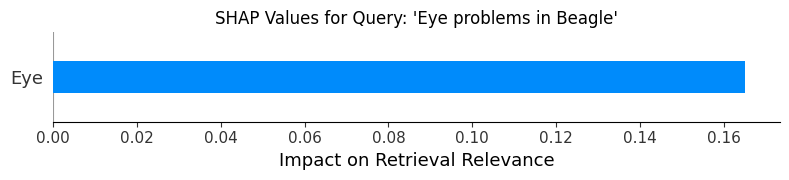

For breed Beagle with health issue Eye problems:
The terms above show how much each word contributed to finding relevant documents.
Positive values mean the term helped find more relevant results.

🔍 Global Feature Importance: Which features most influence health predictions?


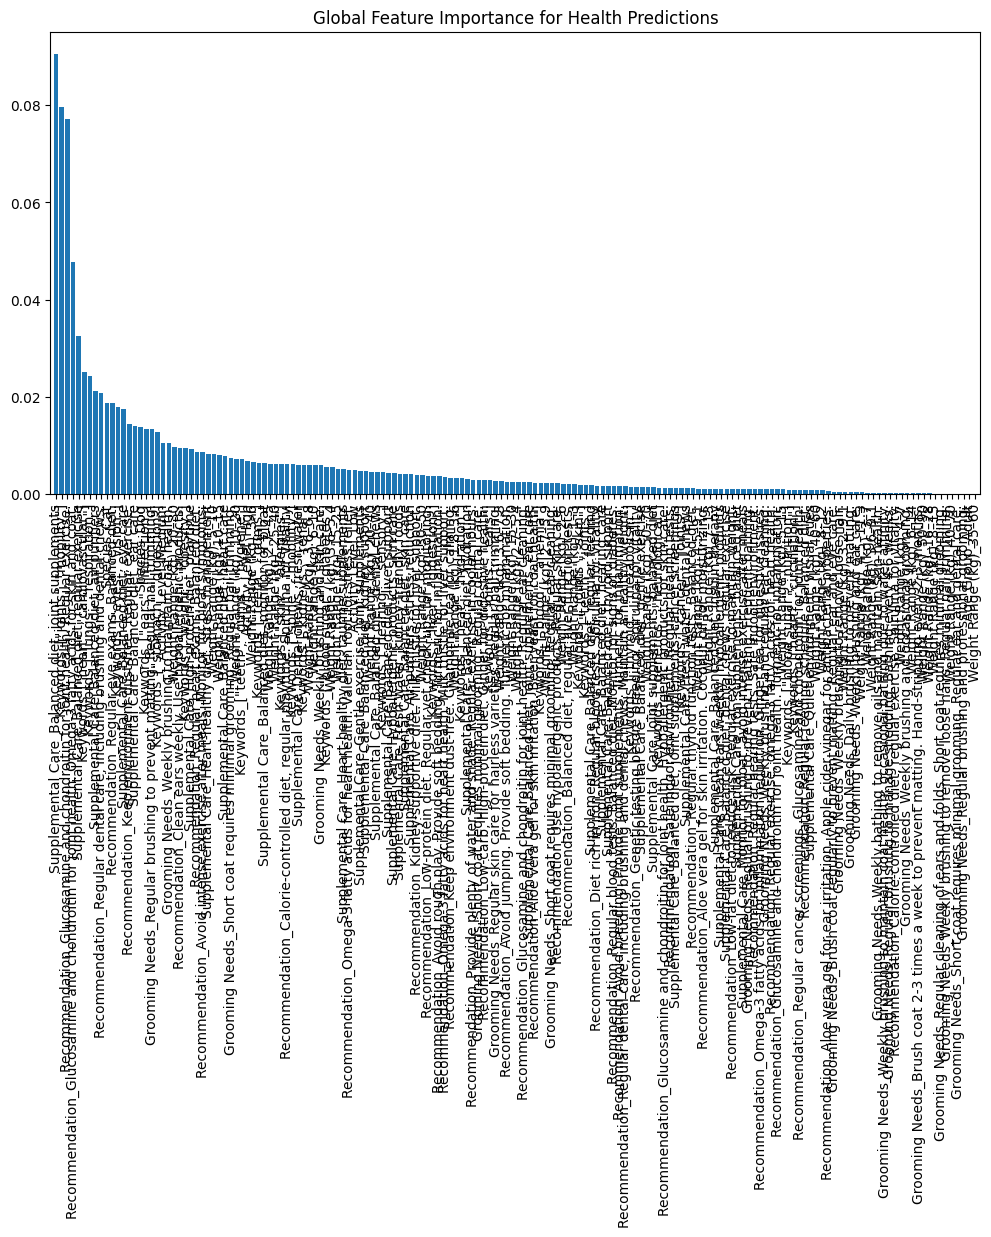

Top features influencing health predictions:
1. Supplemental Care_Balanced diet, joint supplements: 0.091
2. Keywords_["joints", "mobility"]: 0.080
3. Recommendation_Glucosamine and chondroitin for joint health. Regular exercise.: 0.077
4. Recommendation_Glucosamine and chondroitin for joint health. Omega-3 fatty acids for skin and coat.: 0.048
5. Supplemental Care_Balanced diet, regular exercise: 0.032

>> Generated Advice:


📊 Overall Confidence: 12.0%
**Veterinary Advice Generation Task**
    
**Breed:** Beagle
**Health Concern:** Eye problems
**Context Confidence:** Low (based on document relevance)

**Relevant Context Excerpts:**
Breed Name: Beagle
Species: Dog
Primary Health Issue: Eye problems
Recommendation: Regular eye exams. Balanced diet.
Weight Range (kg): 10–20
Age Group: Adult
Activity Level: Medium
Supplemental Care: Balanced diet, eye care
Grooming Needs: Short coat requires minimal grooming. Regular ear cleaning.
Keywords: ["eyes", "vision"]
Breed Name: Cockapoo
Specie

In [32]:
if __name__ == "__main__":
    print("\n> Starting RAG pipeline :) ")
    
    if os.path.exists(VECTOR_DB_PATH):
        shutil.rmtree(VECTOR_DB_PATH)
    
    docs = load_documents()
    if not docs:
        raise ValueError("No documents loaded - check your data paths")
    
    vectorstore = build_or_load_vectorstore(docs, force_rebuild=False)

    
    try:
        df = pd.read_excel(STRUCTURED_DATA_PATH)
    except Exception as e:
        raise ValueError(f"Error loading breed data: {e}")

    breed_name = input("Enter breed name: ").strip()
    breed_row = df[df["Breed Name"] == breed_name]
    
    if breed_row.empty:
        print(f"Breed '{breed_name}' not found")
    else:
        breed_info = breed_row.iloc[0].to_dict()
        
        # Generate both detailed advice and mobile recommendations
        advice = generate_advice(breed_info, vectorstore)
        recommendations = generate_breed_recommendations(breed_info, vectorstore)
        
        # Generate XAI explanations
        query = f"{breed_info['Primary Health Issue']} in {breed_info['Breed Name']}"
        shap_values = generate_shap_explanation(query, vectorstore, breed_info)
        feature_importances, features = calculate_feature_importance(df)
        
        print("\n>> Generated Advice:\n")
        print(advice)
        
        print("\n>> Mobile App Recommendations:\n")
        print(f"# Know More About Me\n")
        print(f"{breed_info['Breed Name']} 🌟️\n")
        print(f"{recommendations['description']} 🌟️\n")
        print("## Tips & Recommendations 🌟️\n")
        print("\n".join(recommendations['tips']))
        print("\n---\n")
        print(f"### Fun Fact 🌟️\n")
        print(f"{recommendations['fun_fact']} 🌟️\n")
        
        # Print summary of XAI explanations
        print("\n" + "="*50 + "\n")
        print(">> Explanation Summary:\n")
        print("1. SHAP Analysis (Local Explanation):")
        print(f"   - Shows which terms in your query '{query}' most influenced the document retrieval")
        print("   - Positive values indicate terms that helped find more relevant documents")
        print("   - Visualized in the SHAP plot above")
        
        print("\n2. Feature Importance (Global Explanation):")
        print("   - Shows which breed characteristics most influence health predictions overall")
        print("   - Based on analysis of all breeds in the dataset")
        print("   - Visualized in the feature importance plot above")
        
        print("\n3. Key Takeaways:")
        print("   - The system's recommendations are based on:")
        print("     * The most relevant documents found for your query")
        print("     * General patterns learned from all breeds in our database")
        print("   - Confidence scores indicate how well-supported each recommendation is")
        
        print("\n" + "="*50 + "\n")
        print("Pipeline completed successfully! 🎉")
        print("You can now:")
        print("1. Review the generated advice and recommendations")
        print("2. Check the visual explanations to understand how the system arrived at these conclusions")
        print("3. Consult with a veterinarian for personalized guidance")